In [6]:
import pandas as pd
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# show all columns
pd.set_option('display.max_columns', None)

In [3]:
demand_df = pd.read_parquet("../data/raw/333623-10.parquet").reset_index(drop=True)
demand_df

,timestamp,out.district_cooling.cooling.energy_consumption,out.district_heating.heating.energy_consumption,out.district_heating.water_systems.energy_consumption,out.electricity.cooling.energy_consumption,out.electricity.exterior_lighting.energy_consumption,out.electricity.fans.energy_consumption,out.electricity.heat_recovery.energy_consumption,out.electricity.heat_rejection.energy_consumption,out.electricity.heating.energy_consumption,out.electricity.interior_equipment.energy_consumption,out.electricity.interior_lighting.energy_consumption,out.electricity.pumps.energy_consumption,out.electricity.refrigeration.energy_consumption,out.electricity.water_systems.energy_consumption,out.natural_gas.heating.energy_consumption,out.natural_gas.interior_equipment.energy_consumption,out.natural_gas.water_systems.energy_consumption,out.district_cooling.total.energy_consumption,out.district_heating.total.energy_consumption,out.electricity.total.energy_consumption,out.natural_gas.total.energy_consumption,out.other_fuel.cooling.energy_consumption,out.site_energy.total.energy_consumption,out.natural_gas.cooling.energy_consumption,out.other_fuel.interior_equipment.energy_consumption,out.other_fuel.water_systems.energy_consumption,out.other_fuel.total.energy_consumption,out.other_fuel.heating.energy_consumption,out.district_heating.cooling.energy_consumption,out.district_cooling.cooling.energy_consumption_intensity,out.district_heating.heating.energy_consumption_intensity,out.district_heating.water_systems.energy_consumption_intensity,out.electricity.cooling.energy_consumption_intensity,out.electricity.exterior_lighting.energy_consumption_intensity,out.electricity.fans.energy_consumption_intensity,out.electricity.heat_recovery.energy_consumption_intensity,out.electricity.heat_rejection.energy_consumption_intensity,out.electricity.heating.energy_consumption_intensity,out.electricity.interior_equipment.energy_consumption_intensity,out.electricity.interior_lighting.energy_consumption_intensity,out.electricity.pumps.energy_consumption_intensity,out.electricity.refrigeration.energy_consumption_intensity,out.electricity.water_systems.energy_consumption_intensity,out.natural_gas.heating.energy_consumption_intensity,out.natural_gas.interior_equipment.energy_consumption_intensity,out.natural_gas.water_systems.energy_consumption_intensity,out.district_cooling.total.energy_consumption_intensity,out.district_heating.total.energy_consumption_intensity,out.electricity.total.energy_consumption_intensity,out.natural_gas.total.energy_consumption_intensity,out.other_fuel.cooling.energy_consumption_intensity,out.site_energy.total.energy_consumption_intensity,out.natural_gas.cooling.energy_consumption_intensity,out.other_fuel.interior_equipment.energy_consumption_intensity,out.other_fuel.water_systems.energy_consumption_intensity,out.other_fuel.total.energy_consumption_intensity,out.other_fuel.heating.energy_consumption_intensity,out.district_heating.cooling.energy_consumption_intensity
0,2018-01-01 00:15:00,0.0,0.0,0.0,0.0,0.444784,2.042863,0.0,0.0,6.480583,2.097362,0.593534,1.484821e-10,0.387383,9.589977,0.0,9.311323,0.0,0.0,0.0,21.636486,9.311323,0.0,30.947809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000059,0.000272,0.0,0.0,0.000864,0.000280,0.000079,1.979761e-14,0.000052,0.001279,0.0,0.001242,0.0,0.0,0.0,0.002885,0.001242,0.0,0.004126,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-01 00:30:00,0.0,0.0,0.0,0.0,0.444784,2.042863,0.0,0.0,6.492953,1.802582,0.589069,1.457525e-10,0.386823,9.426116,0.0,8.680047,0.0,0.0,0.0,21.185190,8.680047,0.0,29.865237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000059,0.000272,0.0,0.0,0.000866,0.000240,0.000079,1.943366e-14,0.000052,0.001257,0.0,0.001157,0.0,0.0,0.0,0.002825,0.001157,0.0,0.003982,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-01 00:45:00,0.0,0.0,0.0,0.0,0.444784,2.042863,0.0,0.0,6.976885,1.213024,0.563644,1.422953e-10,0.386198,9.274258,0.0,7.890952,0.0,0.0,0.0,20.901657,7.890952,0.0,28.792609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000059,

In [4]:
demand_df['timestamp'] = pd.to_datetime(demand_df['timestamp'])
demand_df['hour'] = demand_df['timestamp'].dt.hour
demand_df['day_of_week'] = demand_df['timestamp'].dt.dayofweek
demand_df

,timestamp,out.district_cooling.cooling.energy_consumption,out.district_heating.heating.energy_consumption,out.district_heating.water_systems.energy_consumption,out.electricity.cooling.energy_consumption,out.electricity.exterior_lighting.energy_consumption,out.electricity.fans.energy_consumption,out.electricity.heat_recovery.energy_consumption,out.electricity.heat_rejection.energy_consumption,out.electricity.heating.energy_consumption,out.electricity.interior_equipment.energy_consumption,out.electricity.interior_lighting.energy_consumption,out.electricity.pumps.energy_consumption,out.electricity.refrigeration.energy_consumption,out.electricity.water_systems.energy_consumption,out.natural_gas.heating.energy_consumption,out.natural_gas.interior_equipment.energy_consumption,out.natural_gas.water_systems.energy_consumption,out.district_cooling.total.energy_consumption,out.district_heating.total.energy_consumption,out.electricity.total.energy_consumption,out.natural_gas.total.energy_consumption,out.other_fuel.cooling.energy_consumption,out.site_energy.total.energy_consumption,out.natural_gas.cooling.energy_consumption,out.other_fuel.interior_equipment.energy_consumption,out.other_fuel.water_systems.energy_consumption,out.other_fuel.total.energy_consumption,out.other_fuel.heating.energy_consumption,out.district_heating.cooling.energy_consumption,out.district_cooling.cooling.energy_consumption_intensity,out.district_heating.heating.energy_consumption_intensity,out.district_heating.water_systems.energy_consumption_intensity,out.electricity.cooling.energy_consumption_intensity,out.electricity.exterior_lighting.energy_consumption_intensity,out.electricity.fans.energy_consumption_intensity,out.electricity.heat_recovery.energy_consumption_intensity,out.electricity.heat_rejection.energy_consumption_intensity,out.electricity.heating.energy_consumption_intensity,out.electricity.interior_equipment.energy_consumption_intensity,out.electricity.interior_lighting.energy_consumption_intensity,out.electricity.pumps.energy_consumption_intensity,out.electricity.refrigeration.energy_consumption_intensity,out.electricity.water_systems.energy_consumption_intensity,out.natural_gas.heating.energy_consumption_intensity,out.natural_gas.interior_equipment.energy_consumption_intensity,out.natural_gas.water_systems.energy_consumption_intensity,out.district_cooling.total.energy_consumption_intensity,out.district_heating.total.energy_consumption_intensity,out.electricity.total.energy_consumption_intensity,out.natural_gas.total.energy_consumption_intensity,out.other_fuel.cooling.energy_consumption_intensity,out.site_energy.total.energy_consumption_intensity,out.natural_gas.cooling.energy_consumption_intensity,out.other_fuel.interior_equipment.energy_consumption_intensity,out.other_fuel.water_systems.energy_consumption_intensity,out.other_fuel.total.energy_consumption_intensity,out.other_fuel.heating.energy_consumption_intensity,out.district_heating.cooling.energy_consumption_intensity,hour,day_of_week
0,2018-01-01 00:15:00,0.0,0.0,0.0,0.0,0.444784,2.042863,0.0,0.0,6.480583,2.097362,0.593534,1.484821e-10,0.387383,9.589977,0.0,9.311323,0.0,0.0,0.0,21.636486,9.311323,0.0,30.947809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000059,0.000272,0.0,0.0,0.000864,0.000280,0.000079,1.979761e-14,0.000052,0.001279,0.0,0.001242,0.0,0.0,0.0,0.002885,0.001242,0.0,0.004126,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,2018-01-01 00:30:00,0.0,0.0,0.0,0.0,0.444784,2.042863,0.0,0.0,6.492953,1.802582,0.589069,1.457525e-10,0.386823,9.426116,0.0,8.680047,0.0,0.0,0.0,21.185190,8.680047,0.0,29.865237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000059,0.000272,0.0,0.0,0.000866,0.000240,0.000079,1.943366e-14,0.000052,0.001257,0.0,0.001157,0.0,0.0,0.0,0.002825,0.001157,0.0,0.003982,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,2018-01-01 00:45:00,0.0,0.0,0.0,0.0,0.444784,2.042863,0.0,0.0,6.976885,1.213024,0.563644,1.422953e-10,0.386198,9.274258,0.0,7.890952,0.0,0.0,0.0,20.901657,7.890952,0.0,28.792609,0.0,0.0,0.0,0.0,0.0,0.0,

In [10]:
target = 'out.electricity.total.energy_consumption'
features = ['hour', 'day_of_week']

filtered_df = demand_df[demand_df[target] > 0]
filtered_df = filtered_df.sort_values('timestamp')

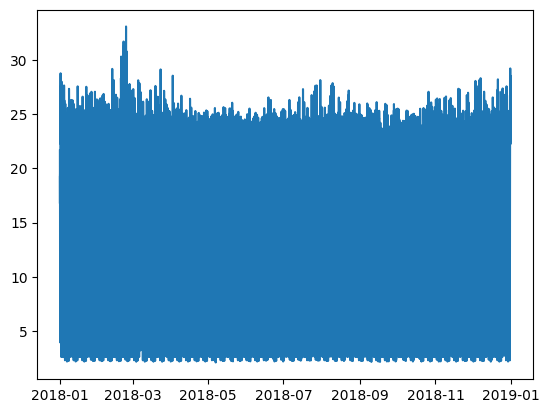

In [12]:
plt.plot(filtered_df['timestamp'], filtered_df[target])

In [19]:
with pm.Model() as model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    betas = pm.Normal('betas', mu=0, sigma=10, shape=len(features))

    # Expected value of outcome (linear model)
    mu = alpha + pm.math.dot(filtered_df[features], betas)

    # Likelihood (sampling distribution) of observations
    sigma = pm.HalfNormal('sigma', sigma=1)
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=filtered_df[target])

    # Posterior distribution
    trace = pm.sample(100, return_inferencedata=False)
    inference_data = pm.to_inference_data(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betas, sigma]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 548 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha     16.119  0.081  15.968   16.271      0.005    0.004     243.0   
betas[0]   0.395  0.004   0.387    0.404      0.000    0.000     290.0   
betas[1]  -0.836  0.016  -0.866   -0.807      0.001    0.001     302.0   
sigma      5.575  0.021   5.532    5.609      0.001    0.001     292.0   

          ess_tail  r_hat  
alpha        268.0   1.01  
betas[0]     241.0   1.01  
betas[1]     231.0   1.01  
sigma        246.0   1.00  


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

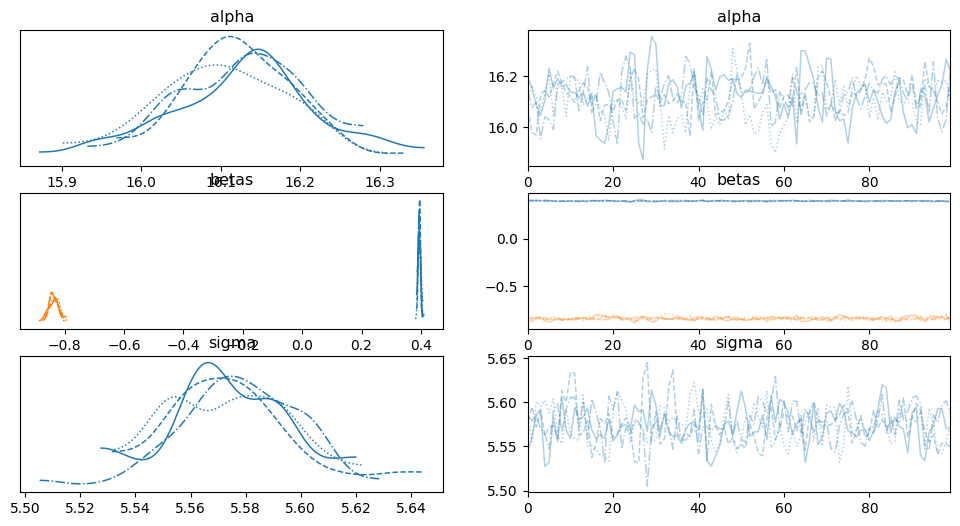

In [20]:
import arviz as az

# Summary of the posterior distribution for model parameters
summary = az.summary(inference_data)
print(summary)

# Plotting the posterior distributions for the coefficients
az.plot_trace(inference_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betas, sigma]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 634 seconds.


array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'betas\n0'}>,
       <Axes: title={'center': 'betas\n1'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

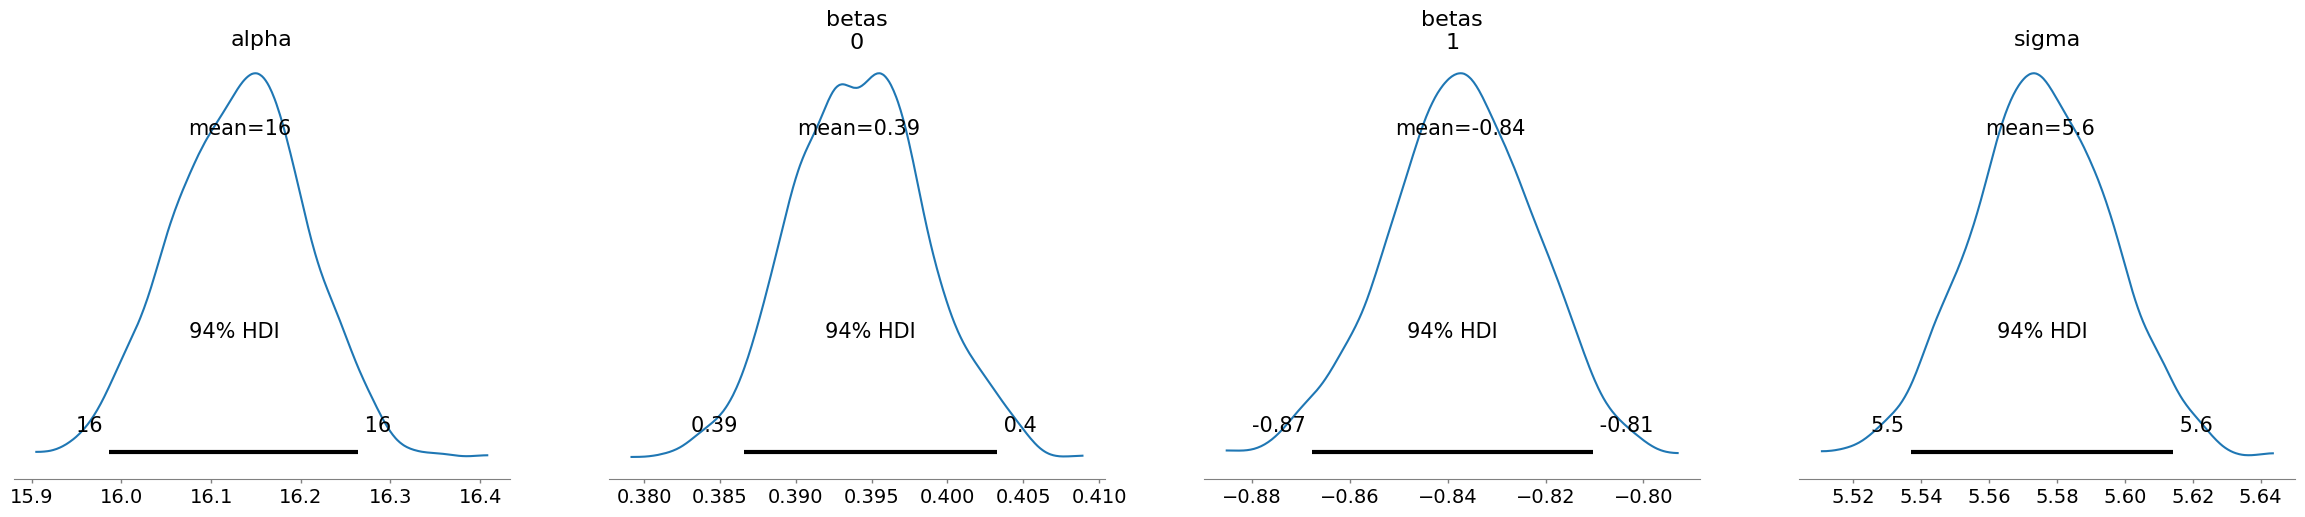

In [21]:
# Perform inference using the model
with model:
    # Sample from the posterior
    posterior_samples = pm.sample(draws=500, tune=500, return_inferencedata=True)

# Display the results
az.plot_posterior(posterior_samples)
